<p style="font-size:32px; font-weight: bolder; text-align: center"> Constant-pressure (PI)MD </p>
<p style="text-align: center"><i> authored by: <a href="mailto:michele.ceriotti@gmail.com"> Michele Ceriotti </a></i></p>

This notebook provides a demonstration to performing constant-pressure simulations using [i-PI](https://ipi-code.org), and serves also as a brief re-cap of how to use the code. You can run this through the notebook, or follow the instructions on the command-line, coming back to the notebook for visualizing the results.  

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
import chemiscope
import pimdmooc
import warnings
pimdmooc.add_ipi_paths()

<a id="setting-up"> </a>

# Setting up a NPT calculation

We consider a (classical) harmonic oscillator with frequency $\omega$ and unit mass, in the constant-temperature ensemble at inverse temperature $\beta$. To keep things simple, we will use the para-hydrogen potential [I. Silvera and V. Goldman, J. Chem. Phys., 69, 4209 (1978)](https://doi.org/10.1063/1.437103) implemented in the FORTRAN driver distributed with i-PI.

## Input files

Inputs to run molecular dynamics in the constant-pressure ensemble can be found in the `01-constant-pressure` folder. You will find a `para-h2.pdb` file that contains the starting positions of the atoms, and `npt-md.xml`, the actual i-PI input. Let's have a look at them.

The first section of the file defines the logging level (`verbosity='medium'`), the content of output files (i-PI does not output unless required) and the total number of simulation steps that should be run

In [7]:
!sed -n '1,7p' 01-constant_pressure/npt-md.xml

<simulation verbosity='medium'>
  <output prefix='ph2-npt-md'>
    <properties filename='md' stride='10'> [step, time{picosecond}, conserved{kelvin}, temperature{kelvin}, potential{kelvin}, kinetic_md{kelvin}, pressure_md{gigapascal}, volume{angstrom3}] </properties>
    <trajectory filename='pos' stride='100' format='pdb' cell_units='angstrom'> positions{angstrom} </trajectory>
    <checkpoint filename='checkpoint' stride='1000' overwrite='True'/>
  </output>
  <total_steps> 5000 </total_steps>


Next comes the definition of the forcefield. In this case (the most common in i-PI) we use a socket to communicate with an external driver. The `<address>` tag specifies the socket name (in this case a UNIX domain socket, it would be the IP or hostname in the case of a TCP/IP socket), while the `name` attribute specifies how this forcefield will be referred to when defining the actual physical interactions. 

In [9]:
!sed -n '8,10p' 01-constant_pressure/npt-md.xml

  <ffsocket mode='unix' name='ph2-ff'>
    <address> ph2-driver</address>
  </ffsocket>


The `<system>` tag defines everything that is system-related. `<initialize>` specifies where to fetch the initial atomic positions and cell size, while `<velocities>` instructs i-PI on how to initialize the particle momenta. Note that we have to specify that the temperature is given in kelvin, as i-PI assumes otherwise that it is provided in atomic units.

`<forces>` specifies how to construct interactions. In this case, we simply fetch them from the single forcefield we have defined, but we shall see how more complicated setups can be realized. 
Finally, `<ensemble>` defines the thermodynamic boundary conditions: in this case, temperature and pressure. 

In [11]:
!sed -n '11,22p' 01-constant_pressure/npt-md.xml

  <system>
    <initialize nbeads='1'>
      <file mode='pdb'> para-h2.pdb </file>
      <velocities mode='thermal' units='kelvin'> 25 </velocities>
    </initialize>
    <forces>
      <force forcefield='driver'/>
    </forces>
    <ensemble>
      <temperature units='kelvin'> 25 </temperature>
      <pressure units='megapascal'> 0 </pressure>
    </ensemble>


The way the position of the atoms should be evolved is specified in the `<motion>` section. In this case, we run molecular dynamics in the `npt` ensemble, which means we also have to specify a `<thermostat>` and a `<barostat>`. We use a Langevin piston barostat, which requires its own separate thermostat. We also specify `<timestep>`, and the time constants of all methods. 

In [16]:
!sed -n '23,40p' 01-constant_pressure/npt-md.xml

    <motion mode='dynamics'>
      <dynamics mode='npt'>
        <thermostat mode='pile_g'>
          <tau units='femtosecond'> 25 </tau>
        </thermostat>
        <barostat mode='isotropic'>
          <thermostat mode='langevin'>
            <tau units='femtosecond'> 50 </tau>
          </thermostat>
          <tau units='femtosecond'> 250 </tau>
        </barostat>
        <timestep units='femtosecond'> 1 </timestep>
      </dynamics>
    </motion>
  </system>
</simulation>


## Running simulations

We are going to launch i-PI from here, but you could do the same opening a terminal. Note that we launch i-PI, wait a couple of second for it to start up and open a socket, and then launch `i-pi-driver` to evaluate energy and forces. We put everything in background and detach the processes from the jupyter instance, so we can continue the execution. **DON'T RE-RUN THE CELL BEFORE THE CALCULATION HAS FINISHED** to avoid conflicts and file overwriting. 

In [41]:
%%bash --bg
cd 01-constant_pressure
PYTHONUNBUFFERED=1 i-pi npt-md.xml &> log &
sleep 2
i-pi-driver -u -a ph2-driver -m sg -o 15 -v &> log.driver

You can view the log from here, or move on to visualize the results

In [44]:
!tail -n 20 01-constant_pressure/log

         </thermostat>
         <barostat mode='isotropic'>
           <thermostat mode='langevin'>
             <tau units='femtosecond'> 50 </tau>
           </thermostat>
           <tau units='femtosecond'> 250 </tau>
         </barostat>
         <timestep units='femtosecond'> 1 </timestep>
       </dynamics>
     </motion>
   </system>
 </simulation>
  ---  end input file content  ---
Backup performed: ph2-npt-md.checkpoint -> #ph2-npt-md.checkpoint#4#
 @SOCKET:   Client asked for connection from . Now hand-shaking.
 @SOCKET:   Handshaking was successful. Added to the client list.
 # Average timings at MD step       0. t/step: 2.94569e-02
 # Average timings at MD step     100. t/step: 3.77482e-02
 # Average timings at MD step     200. t/step: 3.67043e-02
 # Average timings at MD step     300. t/step: 3.52678e-02


## Visualizing and analyzing results

We use some utility functions to read the output of i-PI and visualize it.

In [46]:
md_output = pimdmooc.read_ipi_output('01-constant_pressure/ph2-npt-md.md')

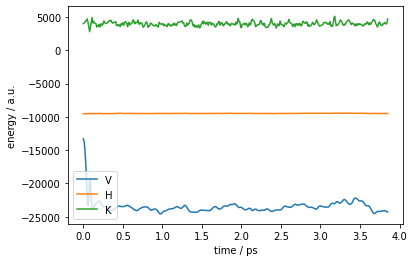

In [56]:
plt.plot(md_output["time"], md_output["potential"], label="V")
plt.plot(md_output["time"], md_output["conserved"], label="H")
plt.plot(md_output["time"], md_output["kinetic_md"], label="K")
plt.xlabel("time / ps"); plt.ylabel("energy / a.u."); 
plt.legend()

In [52]:
warnings.filterwarnings('ignore', '.*residuenumbers array.*')
frames = ase.io.read('01-constant_pressure/ph2-npt-md.pos_0.pdb', ":")

In [55]:
chemiscope.show(frames=frames, mode="structure")

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 108, "names": ["H", "H", "H", "H", "H",…